In [37]:
import csv
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass

In [38]:
TEMPERATURES_CSV = "london_weather.csv"

with open(TEMPERATURES_CSV, 'r') as csvfile:
    print(f"Header looks like this:\n\n{csvfile.readline()}")    
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

Header looks like this:

date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth

First data point looks like this:

19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0

Second data point looks like this:

19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0



In [68]:
def parse_data_from_file(filename):
    
    times = []
    temperatures = []

    with open(filename) as csvfile:
        
# convert string to float
        def conv(s):
            try:
                s=float(s)
            except ValueError:
                pass    
            return s
# reading the file and get values for time and temperature           
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            times.append(row[0])
            temperatures.append(conv(row[6]))
            
    return times, temperatures

In [69]:
times, temperatures = parse_data_from_file("london_weather.csv")

In [124]:
# global class for data
class G:
    TIME = np.array(times[:10000])
    SERIES = np.array(temperatures[:10000])
    SPLIT_TIME = 8000
    WINDOW_SIZE = 64
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000

In [125]:
G.TIME

array(['19790101', '19790102', '19790103', ..., '20060516', '20060517',
       '20060518'], dtype='<U8')

In [126]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

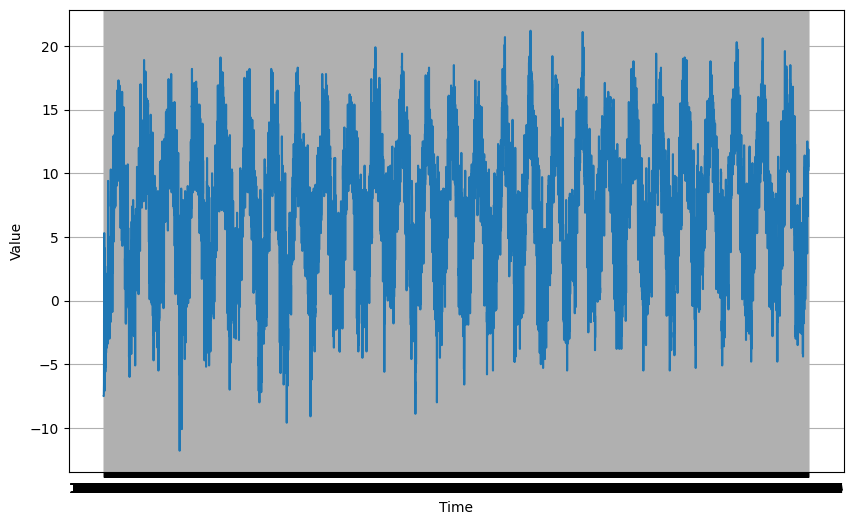

In [127]:
#  plot graph of time and series we can notice the seasonality characteristic of the data
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

In [129]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [130]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


# transform training set to windowed sets
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

In [131]:
def create_uncompiled_model():
# using CNN DNN LSTM for the model  
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[G.WINDOW_SIZE, 1]),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(64, activation = "relu"),
        tf.keras.layers.Dense(32, activation = "relu"),
        tf.keras.layers.Dense(1)
        
    ]) 
    

    return model

In [150]:
def create_model():

    
    model = create_uncompiled_model()

    ### START CODE HERE

    model.compile(loss="Huber",
                  optimizer="adam",
                  metrics=["mae"])  
    

    ### END CODE HERE

    return model

In [151]:
model = create_model()

# Train 
history = model.fit(train_set, epochs=100)

Epoch 1/100


2024-03-28 11:19:50.803782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-28 11:19:50.804297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-28 11:19:50.804830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

248/248 [==============================] - 8s 26ms/step - loss: 2.0309 - mae: 2.4867
Epoch 2/100
248/248 [==============================] - 7s 27ms/step - loss: 1.6494 - mae: 2.0985
Epoch 3/100
248/248 [==============================] - 7s 26ms/step - loss: 1.6299 - mae: 2.0795
Epoch 4/100
248/248 [==============================] - 7s 26ms/step - loss: 1.6121 - mae: 2.0603
Epoch 5/100
248/248 [==============================] - 7s 27ms/step - loss: 1.6006 - mae: 2.0471
Epoch 6/100
248/248 [==============================] - 8s 31ms/step - loss: 1.6160 - mae: 2.0627
Epoch 7/100
248/248 [==============================] - 7s 28ms/step - loss: 1.5859 - mae: 2.0330
Epoch 8/100
248/248 [==============================] - 7s 28ms/step - loss: 1.5804 - mae: 2.0265
Epoch 9/100
248/248 [==============================] - 7s 28ms/step - loss: 1.5974 - mae: 2.0438
Epoch 10/100
248/248 [==============================] - 7s 27ms/step - loss: 1.5823 - mae: 2.0294
Epoch 11/100
248/248 [===================

In [152]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

In [153]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

2024-03-28 11:34:51.266936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [10000]
	 [[{{node Placeholder/_0}}]]
2024-03-28 11:34:51.267254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [10000]
	 [[{{node Placeholder/_0}}]]
2024-03-28 11:34:51.445637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim

      1/Unknown - 0s 470ms/step

2024-03-28 11:34:51.541588: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-28 11:34:51.542552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-28 11:34:51.543353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

311/311 [==============================] - 3s 8ms/step


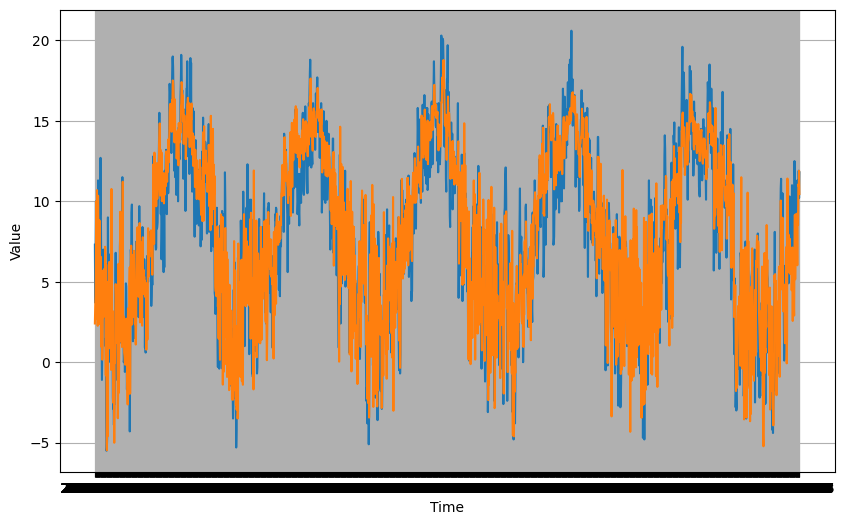

In [154]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot graph
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [155]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 8.94, mae: 2.35 for forecast
